## 1. Setup and Imports
This section installs and imports required libraries, loads results, and prepares the combined dataframe.

In [3]:
import pandas as pd
from pathlib import Path

ROOT = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
R = ROOT / "results"

paths = {
    "PyAnnote": R / "pyannote_predictions.csv",
    "SpeechBrain": R / "speechbrain_predictions.csv",
    "Simple": R / "simple_predictions.csv",
}

dfs = []
for name, p in paths.items():
    dfp = pd.read_csv(p).copy()
    dfp["model"] = name
    dfs.append(dfp)

all_df = pd.concat(dfs, ignore_index=True)
print("Rows per model:")
display(all_df.groupby("model").size())
all_df.head()


Rows per model:


model
PyAnnote       60
Simple         60
SpeechBrain    60
dtype: int64

,audio,language,true_speakers,pred_speakers,runtime_sec,model
0,C:\Users\AboMajed\audio-seg\Audio-AI\audios-wa...,ar,3,3,16.593641,PyAnnote
1,C:\Users\AboMajed\audio-seg\Audio-AI\audios-wa...,en,2,2,13.713065,PyAnnote
2,C:\Users\AboMajed\audio-seg\Audio-AI\audios-wa...,ar,2,2,9.936236,PyAnnote
3,C:\Users\AboMajed\audio-seg\Audio-AI\audios-wa...,ar,3,3,11.928650,PyAnnote
4,C:\Users\AboMajed\audio-seg\Audio-AI\audios-wa...,en,2,3,13.806100,PyAnnote


## 2. Overall Metrics by Model
This section computes and displays overall metrics for each model.

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

rows = []
for model, g in all_df.groupby("model"):
    y_true = g["true_speakers"].astype(int)
    y_pred = g["pred_speakers"].fillna(-1).astype(int)
    rows.append({
        "model": model,
        "accuracy": accuracy_score(y_true, y_pred),
        "precision_macro": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "recall_macro": recall_score(y_true, y_pred, average="macro", zero_division=0),
        "f1_macro": f1_score(y_true, y_pred, average="macro", zero_division=0),
    })

summary = pd.DataFrame(rows).sort_values("f1_macro", ascending=False).reset_index(drop=True)
print("=== Overall metrics by model ===")
display(summary)

# optional: save summary
(summary).to_csv(R / "benchmark_summary_overall.csv", index=False)


=== Overall metrics by model ===


,model,accuracy,precision_macro,recall_macro,f1_macro
0,PyAnnote,0.866667,0.675134,0.65,0.660578
1,SpeechBrain,0.400000,0.301136,0.40,0.322917
2,Simple,0.350000,0.446328,0.35,0.200522


## 3. Per-Language Metrics by Model
This section computes and displays metrics for each model, broken down by language.

In [6]:
rows = []
for (model, lang), g in all_df.groupby(["model","language"]):
    y_true = g["true_speakers"].astype(int)
    y_pred = g["pred_speakers"].fillna(-1).astype(int)
    rows.append({
        "model": model,
        "language": lang,
        "n": len(g),
        "accuracy": accuracy_score(y_true, y_pred),
        "precision_macro": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "recall_macro": recall_score(y_true, y_pred, average="macro", zero_division=0),
        "f1_macro": f1_score(y_true, y_pred, average="macro", zero_division=0),
        "avg_runtime_sec": g["runtime_sec"].mean(),
    })

by_lang = pd.DataFrame(rows).sort_values(["language","f1_macro"], ascending=[True, False]).reset_index(drop=True)
print("=== Per-language metrics by model ===")
display(by_lang)

# optional: save
by_lang.to_csv(R / "benchmark_by_language.csv", index=False)


=== Per-language metrics by model ===


,model,language,n,accuracy,precision_macro,recall_macro,f1_macro,avg_runtime_sec
0,PyAnnote,ar,30,0.866667,0.692308,0.650000,0.660116,11.585018
1,SpeechBrain,ar,30,0.333333,0.243386,0.333333,0.269383,21.853472
2,Simple,ar,30,0.333333,0.111111,0.333333,0.166667,83.466942
3,PyAnnote,en,30,0.866667,0.672222,0.650000,0.660526,12.499233
4,SpeechBrain,en,30,0.466667,0.368530,0.466667,0.377897,22.635360
5,Simple,en,30,0.366667,0.448276,0.366667,0.231546,115.059732


## 4. Visualization
This section visualizes the metrics using bar plots.

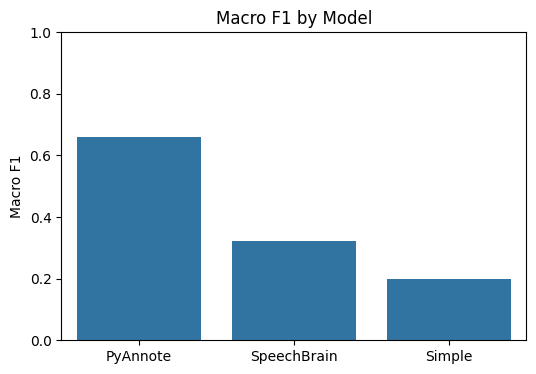

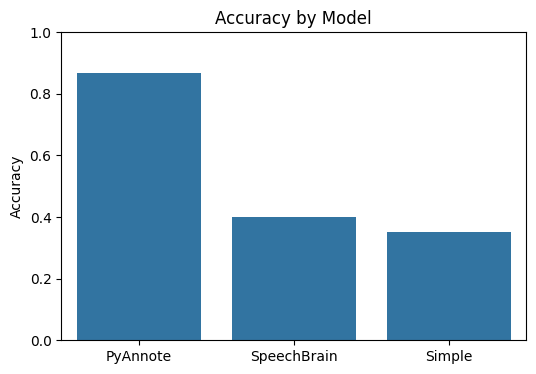

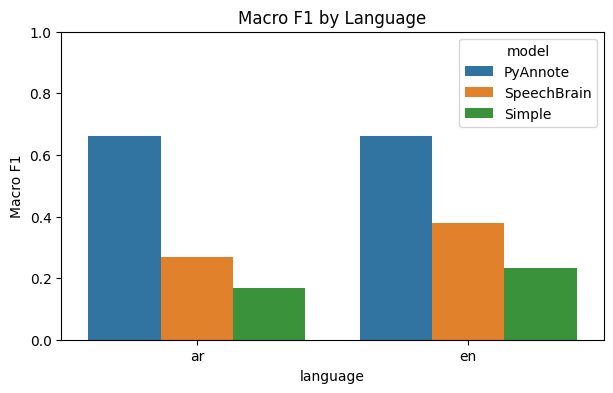

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.barplot(data=summary, x="model", y="f1_macro")
plt.ylim(0,1); plt.ylabel("Macro F1"); plt.xlabel(""); plt.title("Macro F1 by Model")
plt.show()

plt.figure(figsize=(6,4))
sns.barplot(data=summary, x="model", y="accuracy")
plt.ylim(0,1); plt.ylabel("Accuracy"); plt.xlabel(""); plt.title("Accuracy by Model")
plt.show()

plt.figure(figsize=(7,4))
sns.barplot(data=by_lang, x="language", y="f1_macro", hue="model")
plt.ylim(0,1); plt.ylabel("Macro F1"); plt.title("Macro F1 by Language"); plt.show()
